In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [2]:
class CFG:
    seed = 42    
    img_dim1 = 20
    img_dim2 = 10
    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

### Импортируем данные + изменим формат данных для некоторых столбцов

In [3]:
# Read the file
df = pd.read_excel('./test_BND.xlsx', usecols="A:I")
# Drop the number of vehicle
df.drop(columns=['Номер машины'], inplace=True)
# Convert the total time to float format (hours)
df['Суммарное время маршрутов'] = df['Суммарное время маршрутов'].astype('str').str.split(':').apply(lambda x: int(x[0]) + int(x[1])/60)
# Get the weekday for each ovservation (monday = 0)
df['weekday'] = df['Дата смены'].dt.weekday

### Проведем первичный анализ данных

Проверим на missing values (около 20% пропущенных при небольшом размере датасета)

In [4]:
tmp = ((df.isna().sum() / df.shape[0]).to_frame()).reset_index().rename(columns={'index': 'columns',
                                                           0: 'missing'})
tmp

,columns,missing
0,Дата смены,0.000000
1,Отчетная смена,0.000000
2,Суммарное время маршрутов,0.000000
3,Кол. маршрутов,0.000000
4,"Объем по данным контроллера ИПЭ-13, м3",0.000000
5,"Наполнение, м3/кузов",0.192308
6,Коэффициент наполнения кузова,0.192308
7,"Цикличность, секунд",0.192308
8,weekday,0.000000


Построим графики в зависимости от времени для всех переменных

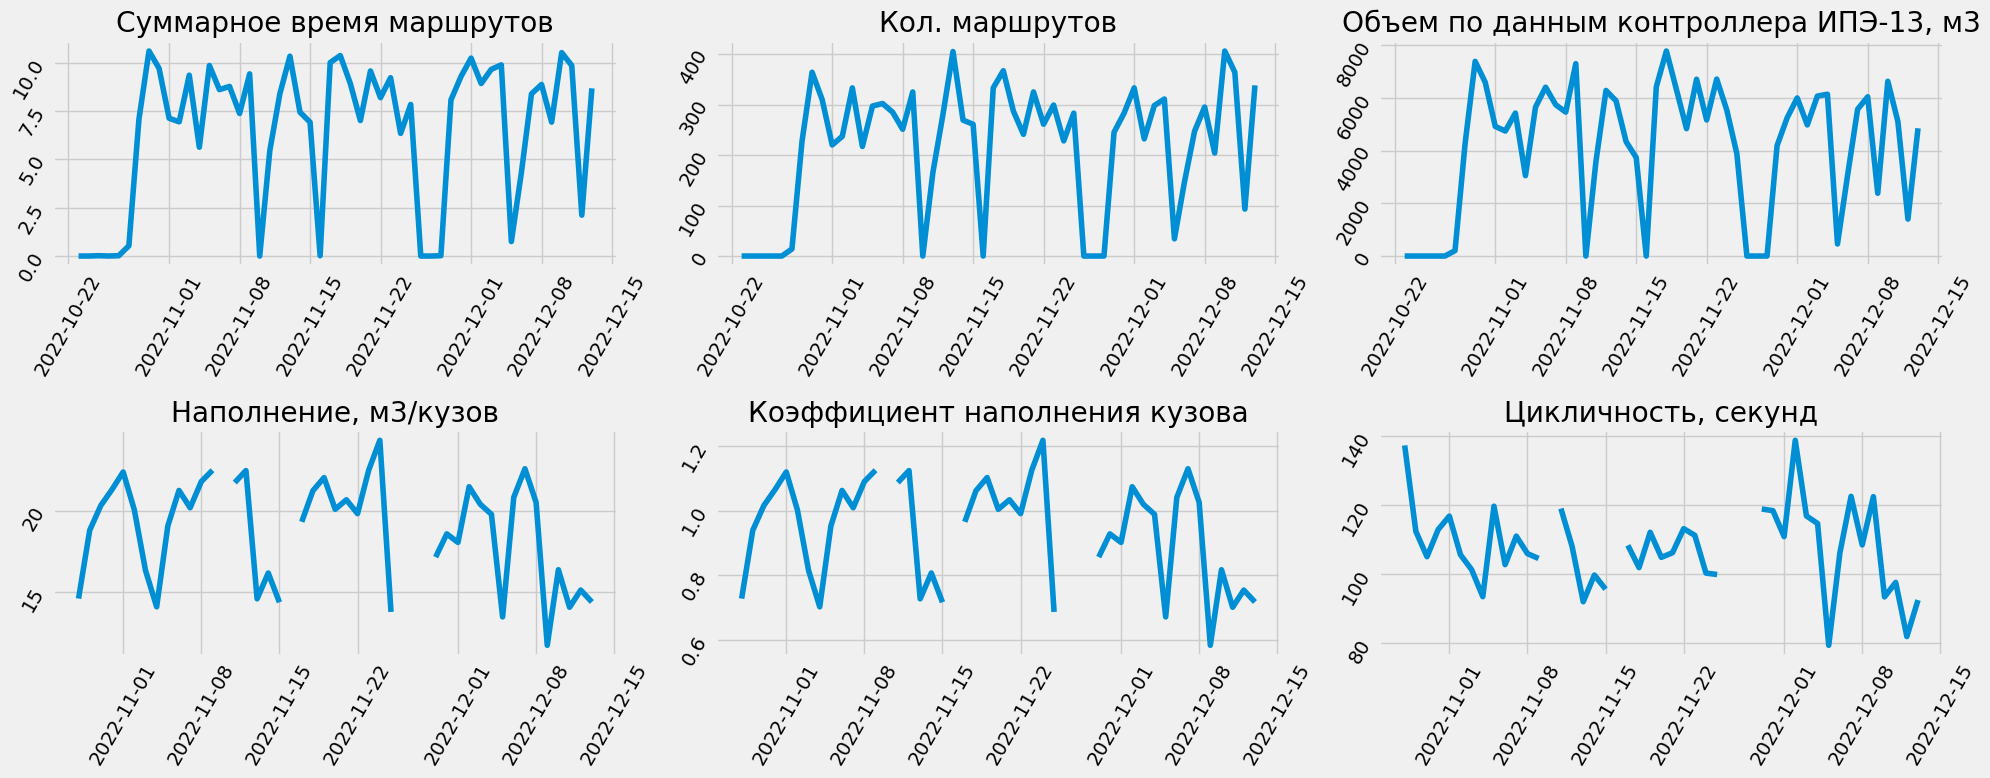

In [5]:
fig, ax = plt.subplots(2,3, figsize=(20,8))

ax = ax.ravel()

cols = df.columns[2:-1]

for i in range(6):
    ax[i].plot(df['Дата смены'], df[cols[i]])
    ax[i].set_title(f'{cols[i]}')
    ax[i].tick_params(rotation=60)
    
fig.tight_layout();

+ В целом не наблюдается какого-либо паттерна в данных
+ Что можно исследовать?
    + Поведение переменных по дням недели   
    + Распределение переменных в зависимости от смены

Можно также взглянуть на распределения данных

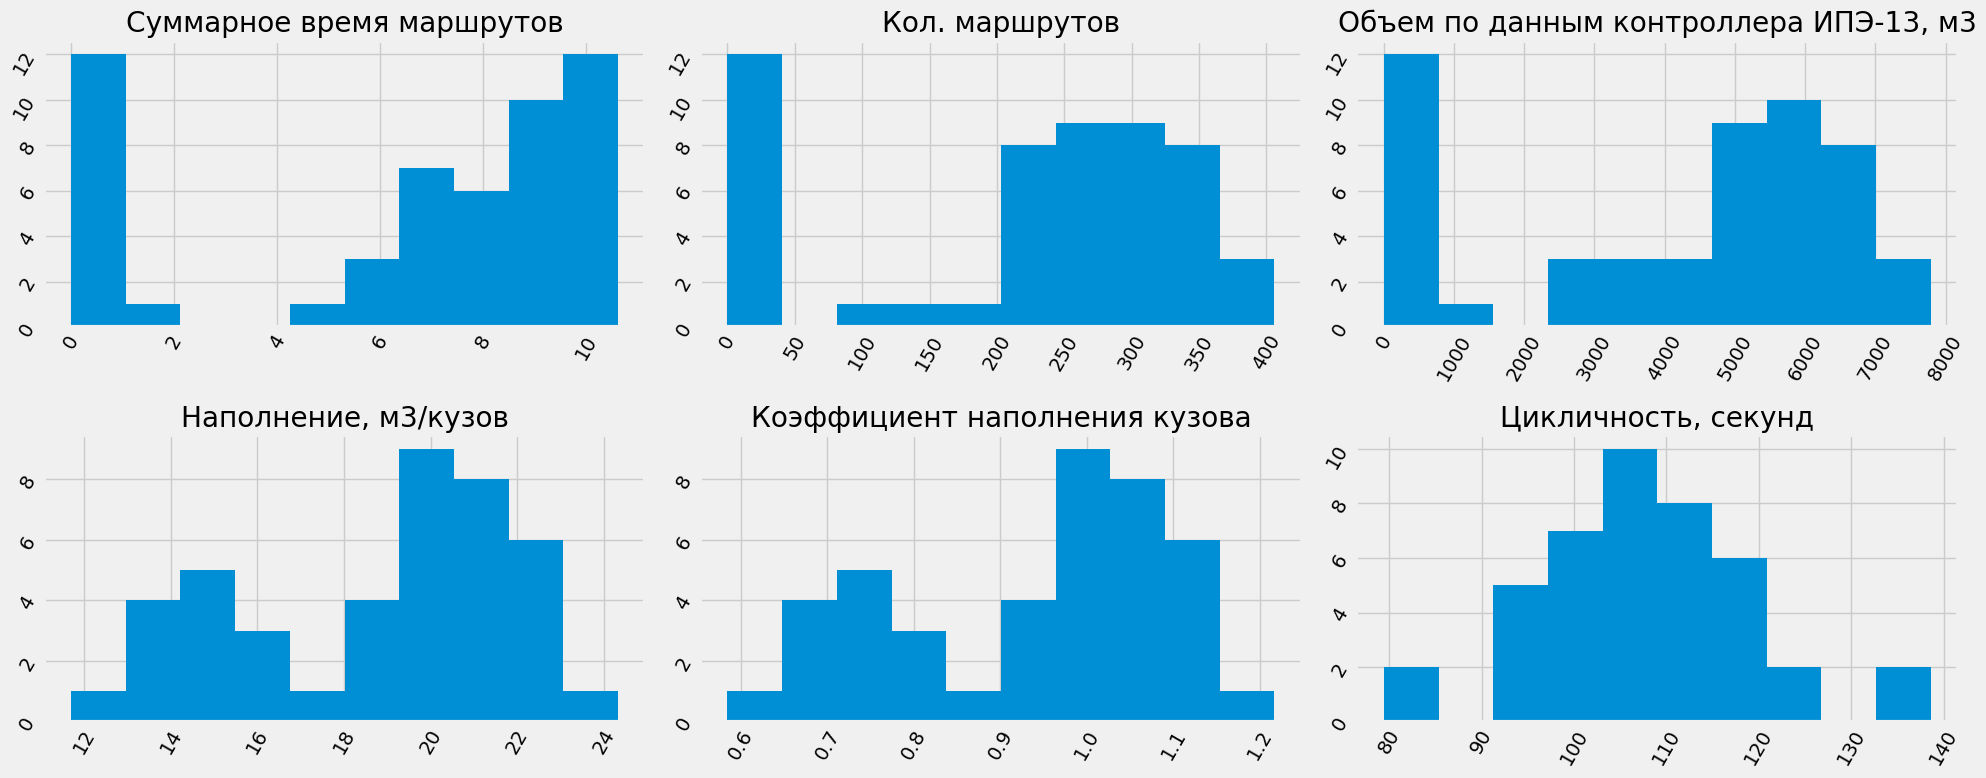

In [6]:
fig, ax = plt.subplots(2,3, figsize=(20,8))

ax = ax.ravel()

cols = df.columns[2:-1]

for i in range(6):
    ax[i].hist(df[cols[i]])
    ax[i].set_title(f'{cols[i]}')
    ax[i].tick_params(rotation=60)
    
fig.tight_layout();

Видно, что распределения не похожи на нормальные
 + Время маршрутов, количестов маршрутов, объем перевозок имеют негативный коэфициент ассиметрии
 + Наполнение кузова и коэффициент наполнения имеют бимодальное распределение
 + Цикличность отдаленно напоминает нормальное (можно отдельно поверять тестом Колмогорова)

Важно отметить, что наблюдений в выборке мало. Поэтому для тестирования гипотез, например о разности средних по сменам для нельзя применять ЦПТ. Также нельзя использовать t-статистики, так как предположение о нормальности не будет выполняться для всех величин. Для того, чтобы прогонять OLS-регрессии и говорить о влиянии каких-либо факторов на объем перевозок так же слишком мало наблюдений. Но все это возможно на больших выборках из данных

### Посмотрим как среднее по данным показателям распределено по дням недели

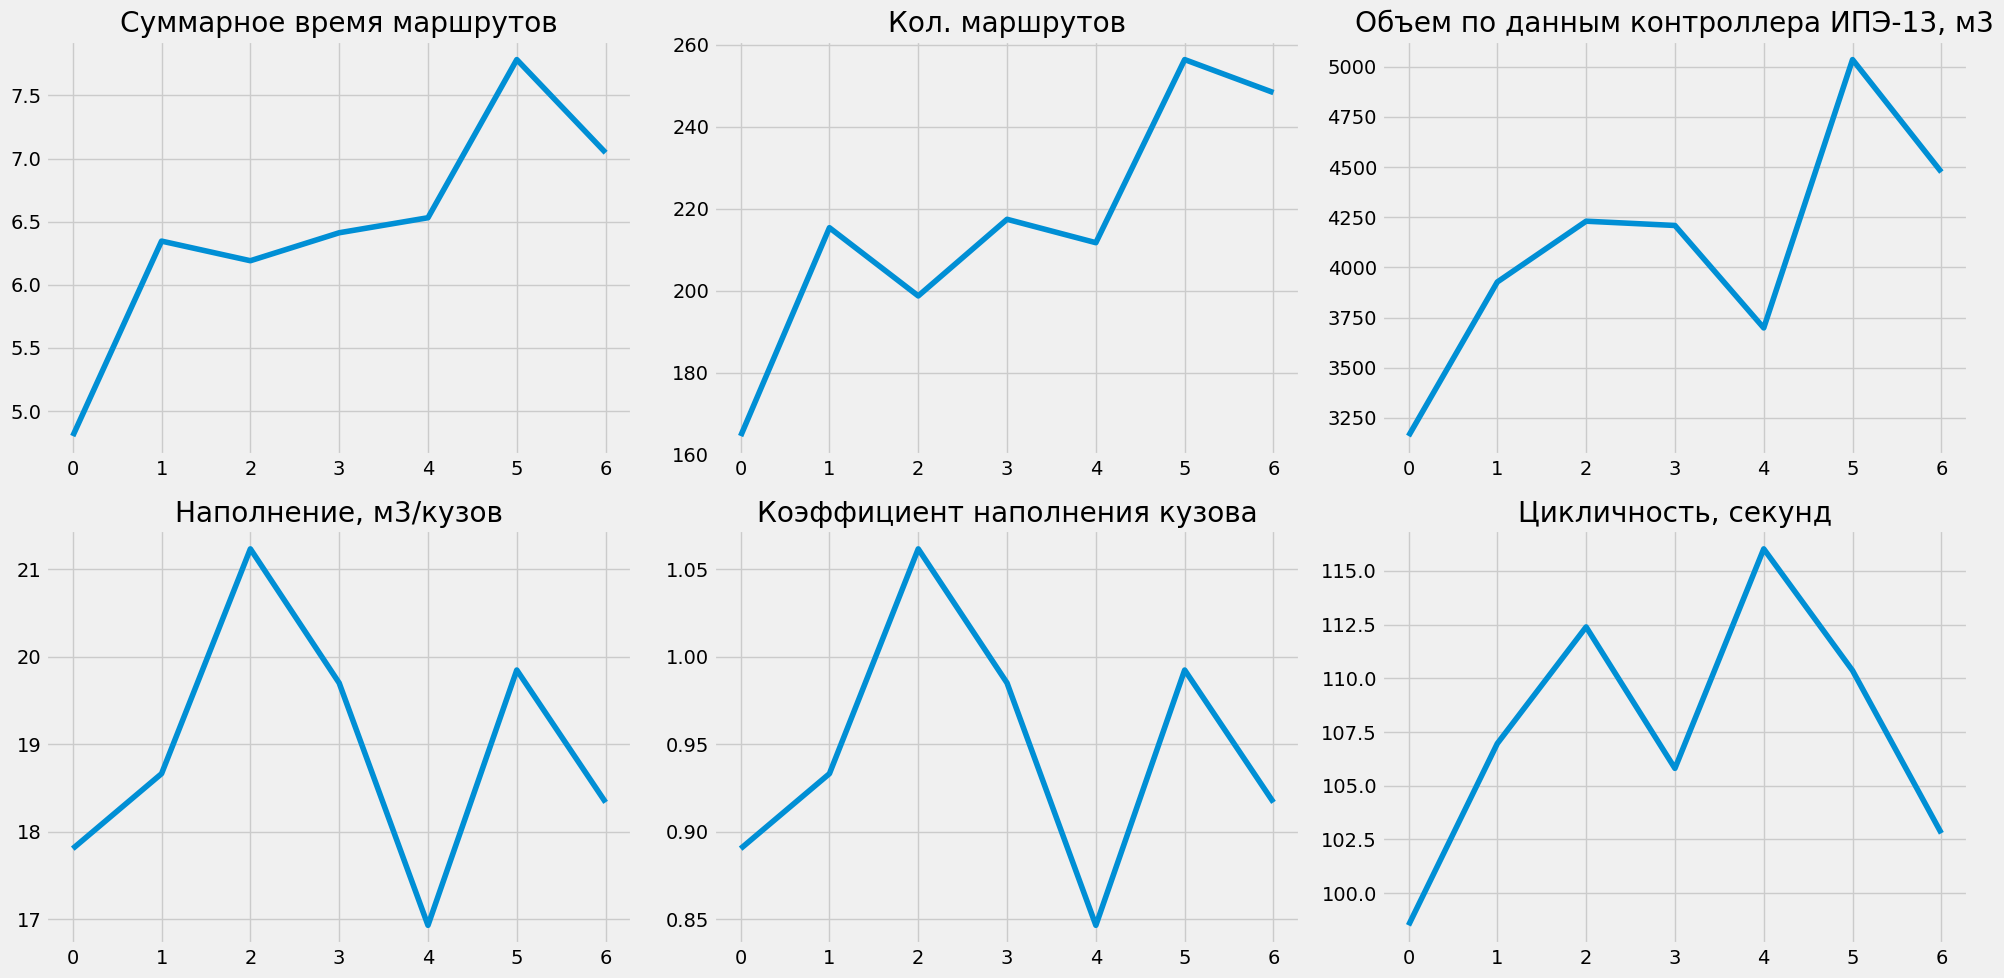

In [7]:
tmp = df.groupby('weekday', as_index=False).mean().drop(columns=['Отчетная смена'])

fig, ax = plt.subplots(2, 3)

cols = tmp.columns[1:]

ax = ax.ravel()

for i in range(6):
    ax[i].plot(tmp['weekday'], tmp[cols[i]])
    ax[i].set_title(f"{cols[i]}")
fig.tight_layout();

Что можно заметить?
+ Наибольшее среднее значение объема по даннам контролера достигается в субботу
    + В этот день в среднем самосвал совершает большее число поездок с коэффициентом наполнения кузова близким к 1, и при этом не с самой низкой цикличностью
    + При этом в четверг, как наименее продуктивный день, наблюдается самый малый коэфициент наполнения кузова, при этом самая высокая цикличность, и относительно невысокое количество маршрутов
    + Также интересно сравнить среду и четверг. Объем в эти дни примерно одинаковый, но достигается за счет разных факторов. Для среды: большой коэфициент наполнения (>1) играет большую роль. Для четверга: самая низкая цикличность.
+ Хотелось бы понять, какой вклад в результат вносят совокупность количества маршрутов, цикличности и коэфциента наполнения (но прогонять регрессию на таком малом количестве наблюдений не имеет смысла)

### Разница между сменами

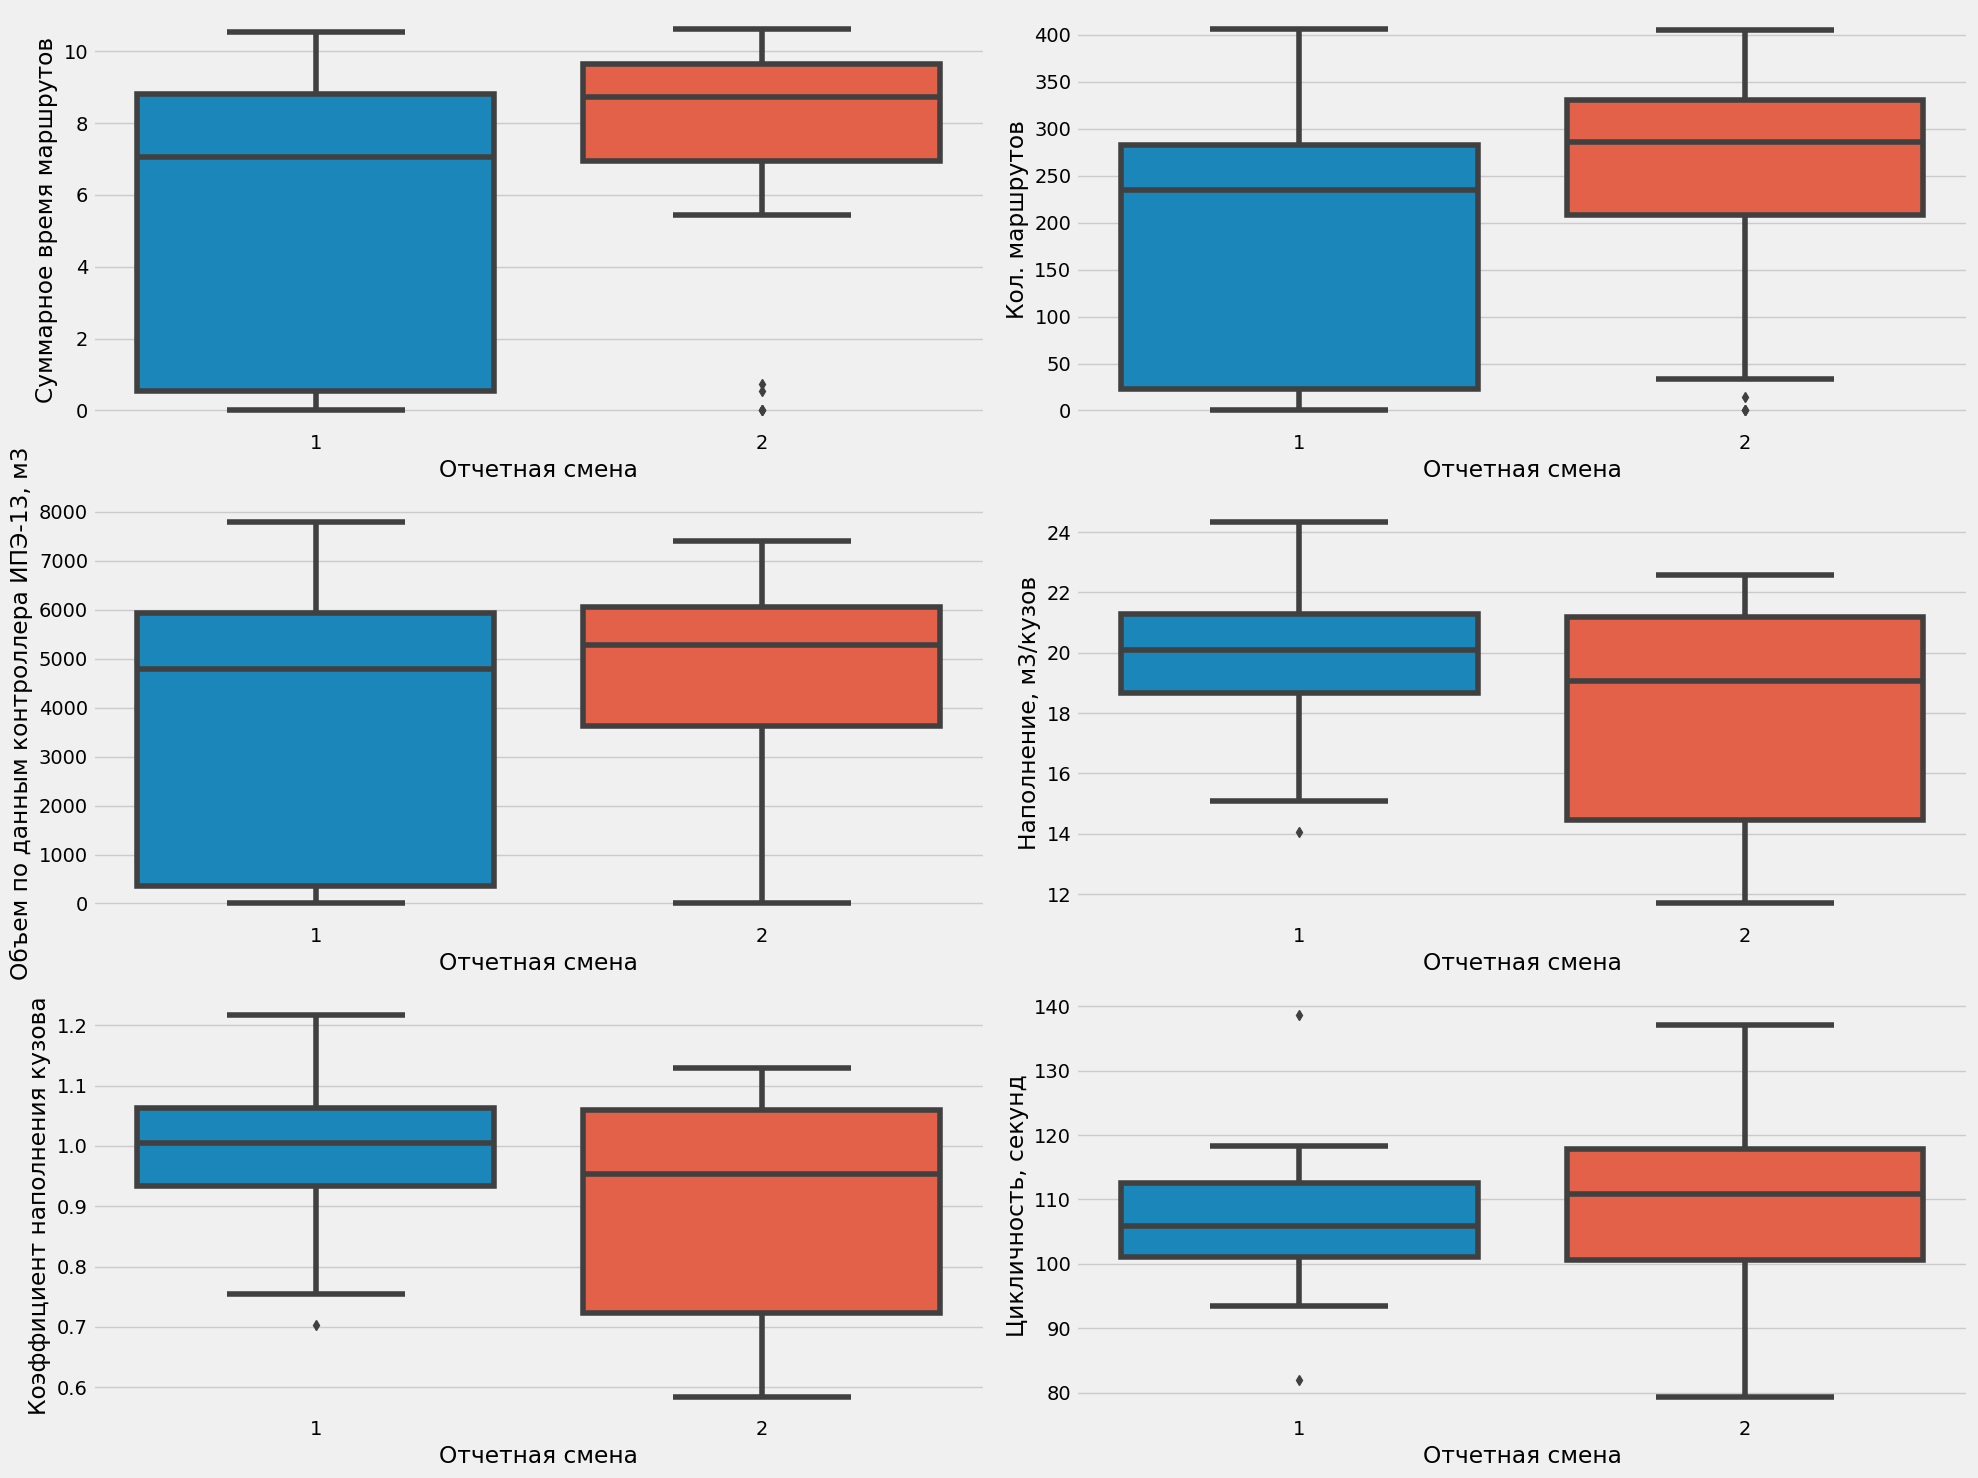

In [8]:
fig, ax = plt.subplots(3, 2, figsize=(20,15))

cols = df.columns[2: -1]

ax = ax.ravel()

for i in range(6):
    sns.boxplot(y = df[cols[i]], x=df['Отчетная смена'], ax=ax[i])

fig.tight_layout();

Выводы:
+ Среднее значение колонок суммарное время маршрутов, количество маршрутов, объекм перевозок, цикличность выше для второй смены
+ Средниий коэфициент наполнения кузова выше для первой смены

### Как разные распределены совместно с объемом перевозок? Как они распределены между собой?

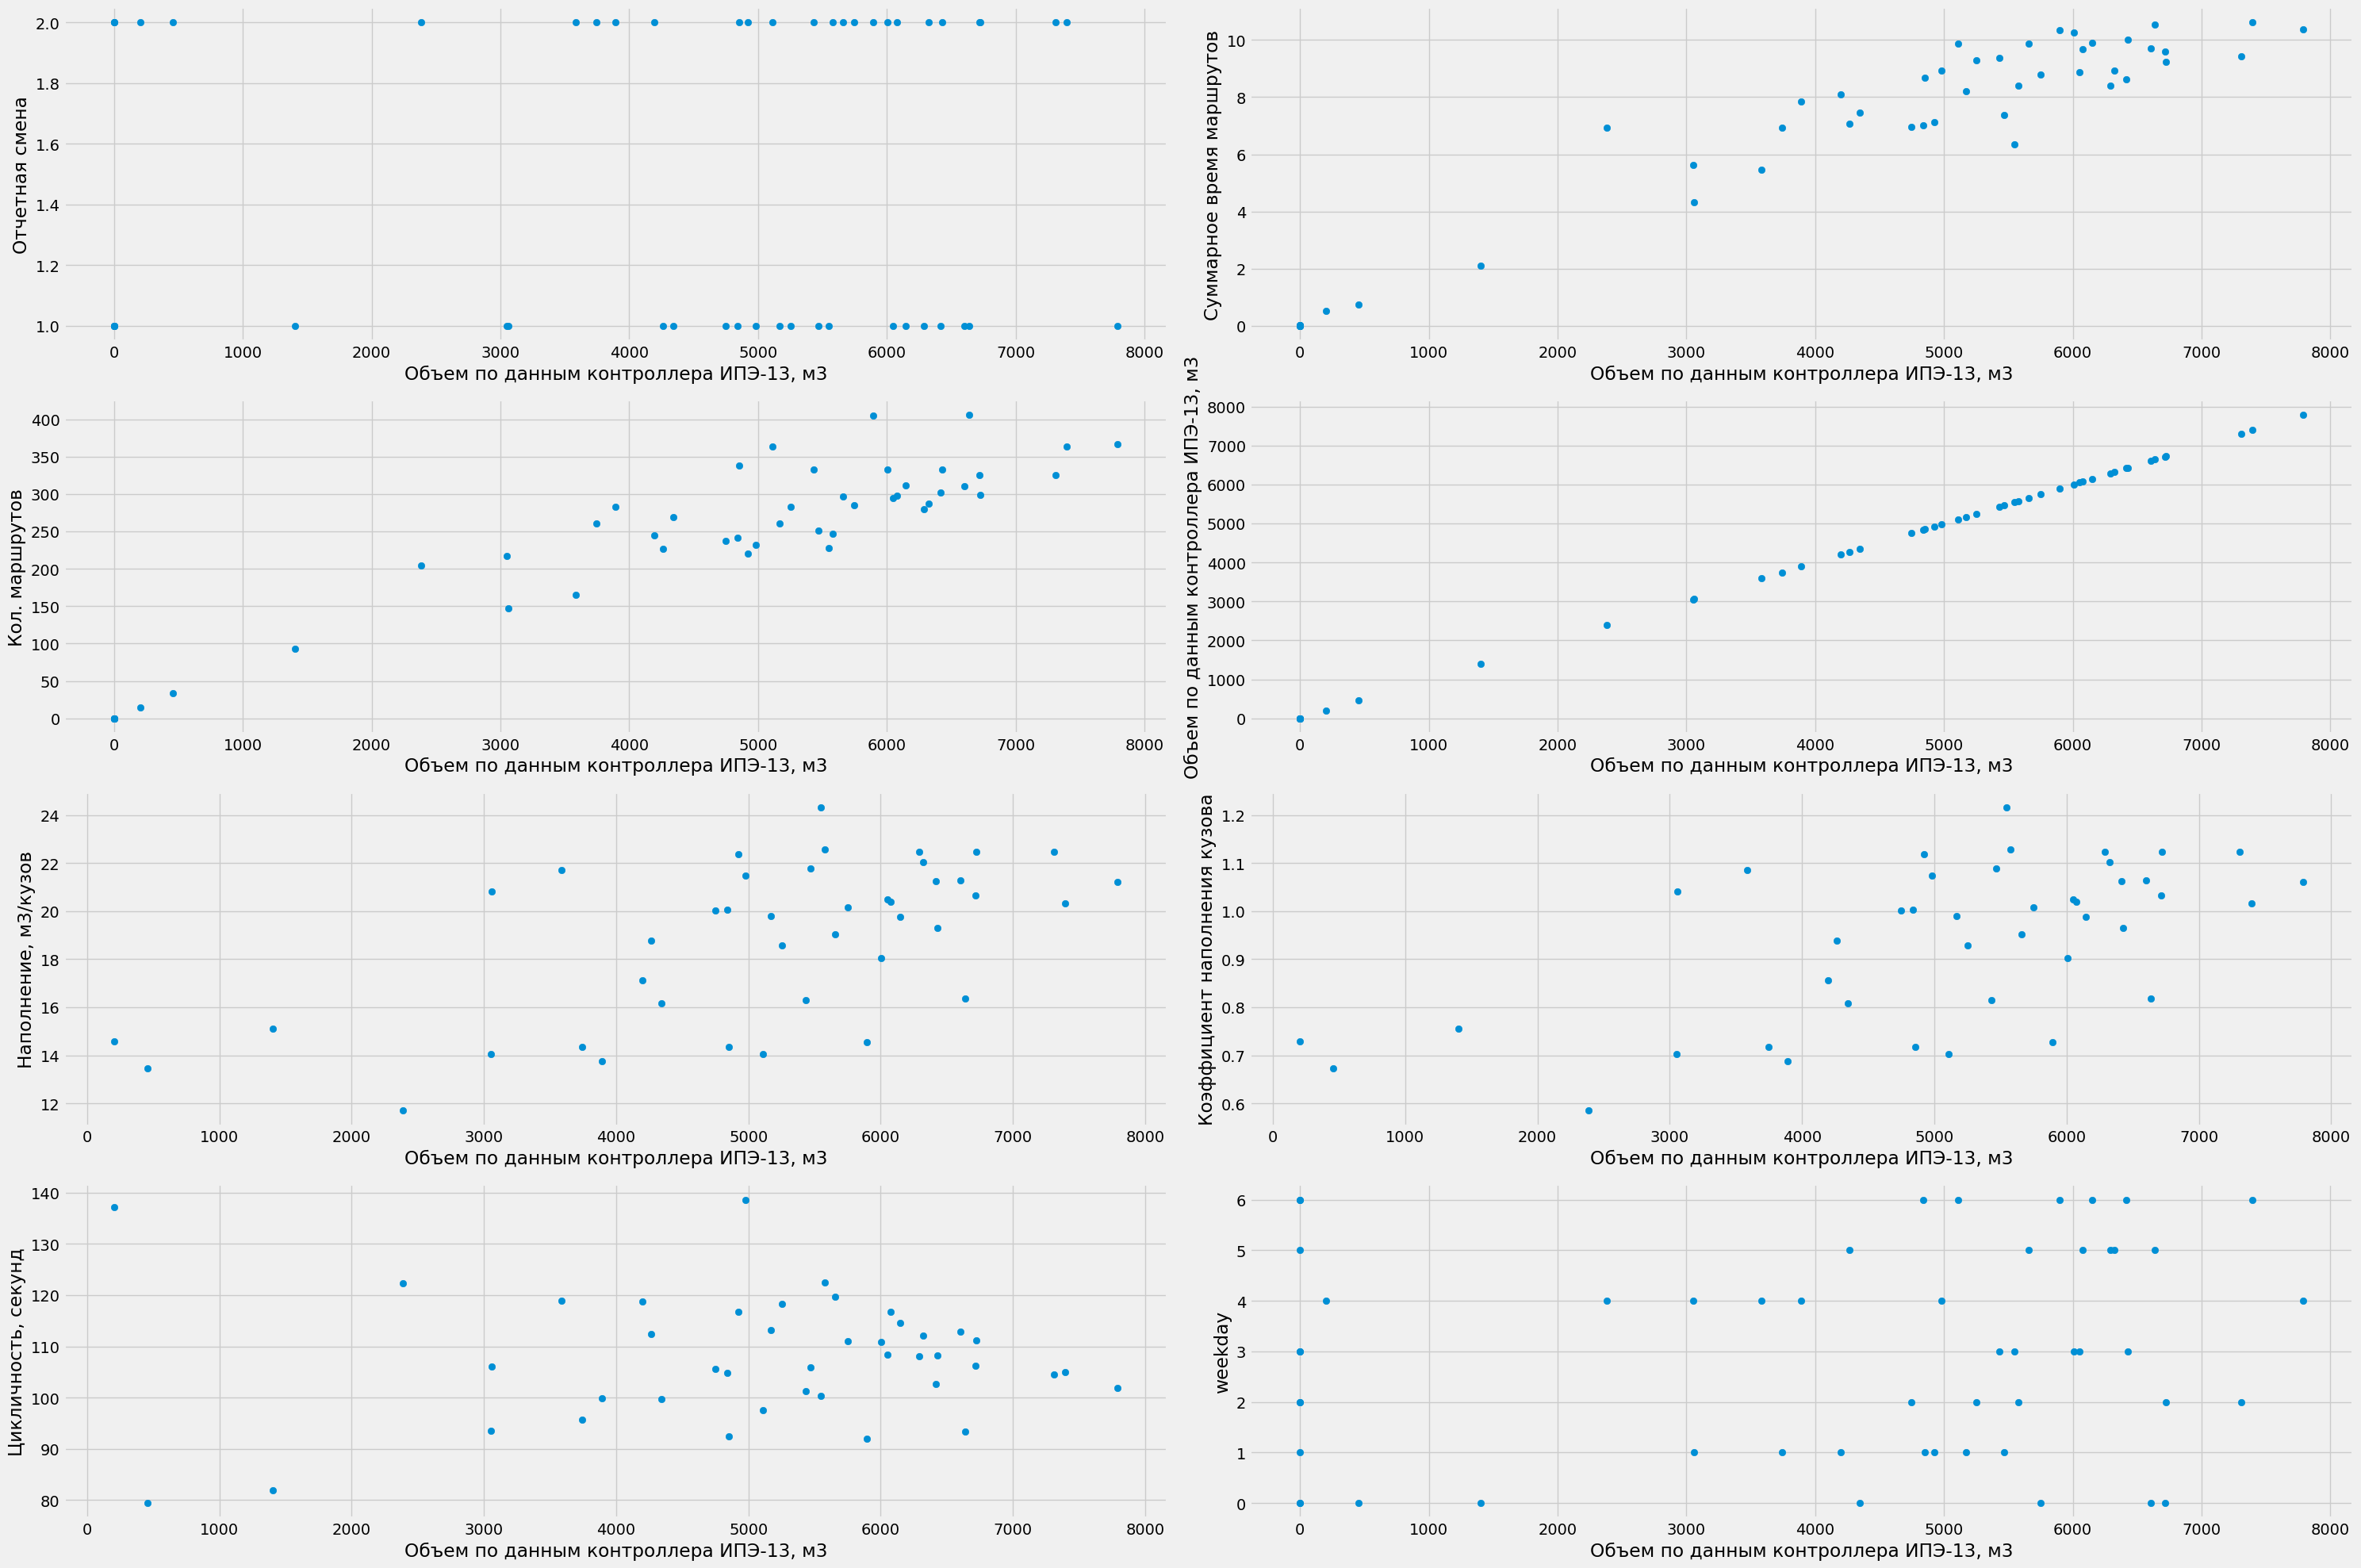

In [9]:
fig, ax = plt.subplots(4, 2, figsize=(30,20))

cols = df.columns[1:]

ax = ax.ravel()

for i in range(8):
    ax[i].scatter(df['Объем по данным контроллера ИПЭ-13, м3'], df[cols[i]])
    ax[i].set_xlabel('Объем по данным контроллера ИПЭ-13, м3')
    ax[i].set_ylabel(f'{cols[i]}')

fig.tight_layout();

Выводы:
+ Как видно, количество маршрутов и суммароное время маршрутов имеют довольно близкую к линейной взаимосвязь с объемом перевозок.
+ При этом цикличность и коэффициент наполнения кузова имеют нелинейную взаимосвязь с объемом перевозок. Это может объясняться тем, что при большем наполнении кузова возрастает значени цикличности, а при меньшем оно падает, что уравновешивает влияние на объем перевозок. Для того, чтобы в этом убедиться посмтроим совместное распределие этих двух переменных

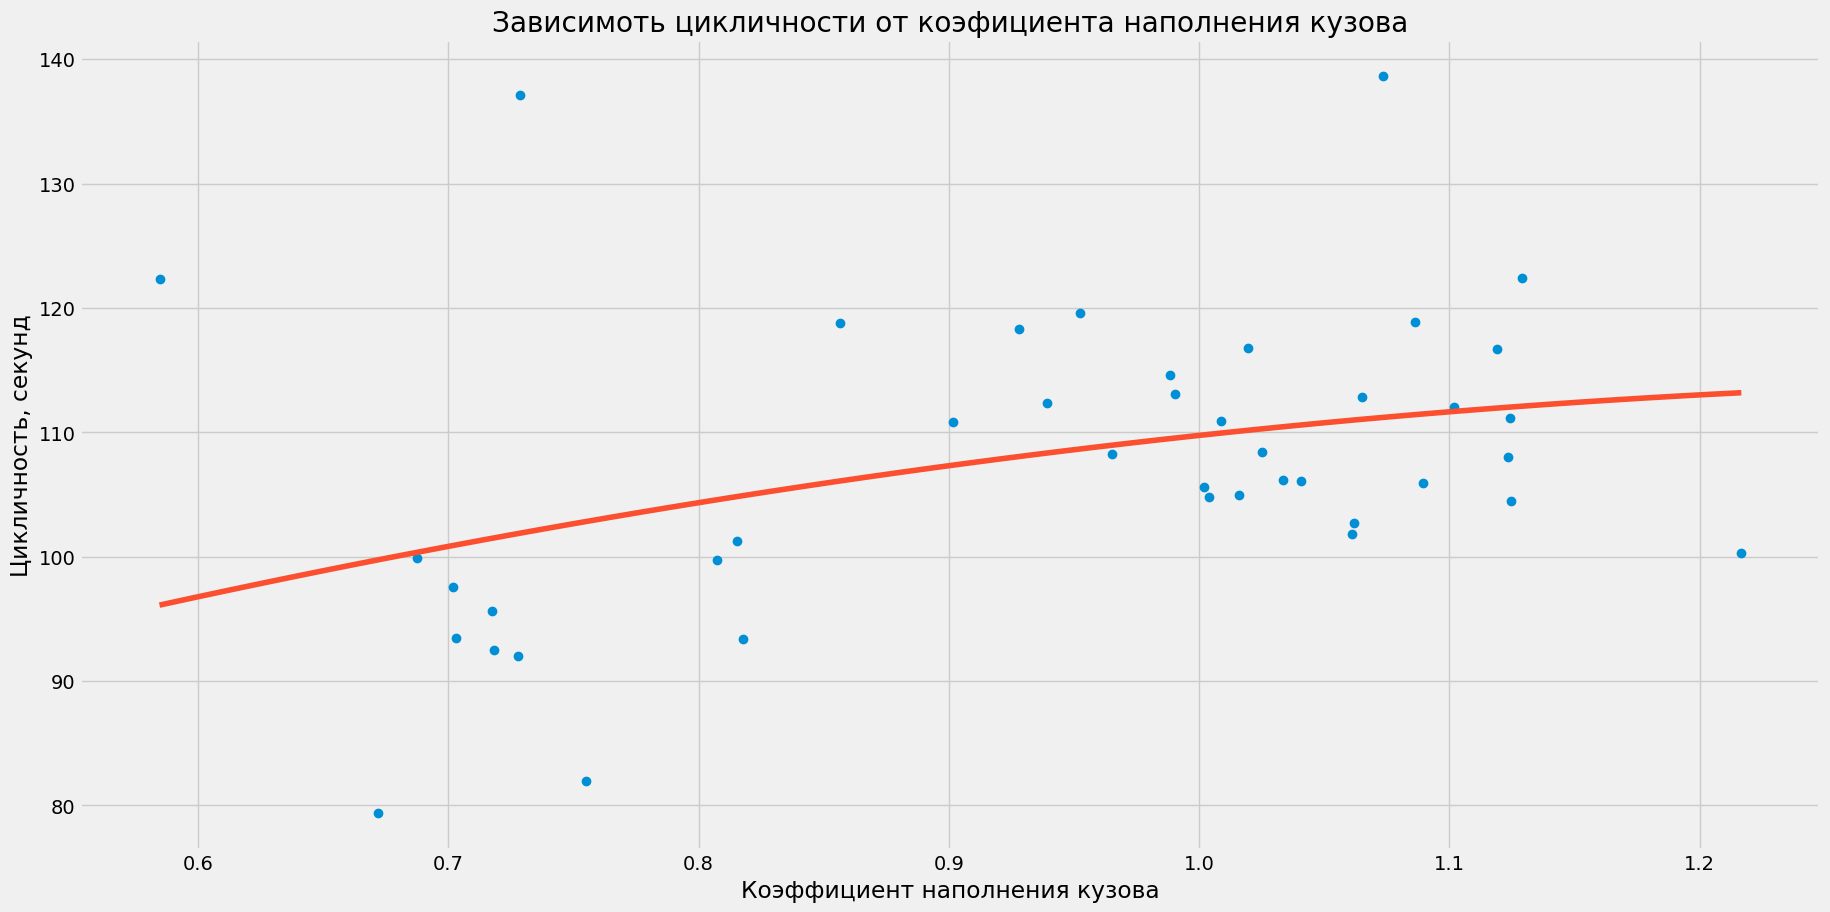

In [10]:
fig, ax = plt.subplots()

df_temp = df.dropna()

x = df_temp['Коэффициент наполнения кузова']
y = df_temp['Цикличность, секунд']


z = np.polyfit(x, y, 2)
f = np.poly1d(z)

x_new = np.linspace(x.min(), x.max(), 50)
y_new = f(x_new)

ax.plot(x,y,'o', x_new, y_new)

ax.set_xlabel('Коэффициент наполнения кузова')
ax.set_ylabel('Цикличность, секунд')
ax.set_title('Зависимоть цикличности от коэфициента наполнения кузова');

Как видно, зависимость действительно положительная и убывающая: $f'(x) > 0$; $f''(x) < 0$ если приближать ее полиномом второй степени